# Comparing total hydrostatic masses measured by LoCuSS and XGA

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS sample has hydrostatic mass measurements associated with them which we will compare to but the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [01:09<02:10,  4.06s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [01:31<02:17,  5.10s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [01:40<01:14,  3.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1682 does not appear to have any XMM data, and

Setting up Galaxy Clusters:  63%|████████████████████████████▎                | 29/46 [01:48<00:56,  3.35s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell1758N has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  65%|█████████████████████████████▎               | 30/46 [01:54<01:03,  3.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:966: UserWarning: A previous annular spectra profile fit for Abell1763 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  70%|███████████████████████████████▎             | 32/46 [02:18<01:57,  8.37s/it]/mnt/pact/dt237/code/PycharmP

## Reading in literature data

###   $\color{red}{\text{Hydrostatic masses from literature}}$

In [4]:
loc_lit_m500s = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_m500s = Quantity(loc_lit_m500s, 'Msun')

loc_lit_m2500s = [locuss[locuss['name'] == n].iloc[0][['x_m2500', 'x_m2500_err', 'x_m2500_err']].values
               for n in locuss_srcs.names]
loc_lit_m2500s = Quantity(loc_lit_m2500s, 'Msun')

## Hydrostatic Mass Comparison to Literature

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.3$R_{500}$

In [5]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [6]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [7]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'}]

In [8]:
loc_sb_dblbeta_simpvikh_13_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.3, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

Generating products of type(s) spectrum: 100%|████████████████████████████| 216/216 [2:02:14<00:00, 33.95s/it]
Generating products of type(s) annular spectrum set components: 100%|███| 2826/2826 [3:18:45<00:00,  4.22s/it]
Running XSPEC Fits: 100%|█████████████████████████████████████████████████▉| 589/590 [39:06<01:56, 116.30s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:59: UserWarning: An XSPEC fit for Abell2204 has timed out
  warnings.warn("An XSPEC fit for {} has timed out".format(source_name))
Running XSPEC Fits: 100%|█████████████████████████████████████████████████| 590/590 [1:06:40<00:00,  6.78s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0697 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: ZwCl0857.9+2107 annular spectra profile fit was not succe

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1340.56613268 1008.37730316 1403.18934509 1385.41497555 1413.74163345
 1424.60972629]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▌       | 2/32 [00:51<12:49, 25.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1641.18680073 1373.35074642 1936.64783752 1728.66054515 1865.63275746
 1934.68436258]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▊       | 3/32 [01:15<12:06, 25.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 345.27884609  869.87984003  949.7713692   993.11811348 1079.38697399
 1184.68495953]


Fitting data, inverse Abel transforming, and measuring densities:  12%|█       | 4/32 [01:40<11:42, 25.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [206.57384288 463.39388312 148.32747639 200.72211974 294.06165773
 233.39344213]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▎      | 5/32 [02:06<11:21, 25.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [140.62856793 350.85443982 387.89951032 273.14540189 327.4973015
 403.48324439]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▌      | 6/32 [02:34<11:20, 26.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 462.61999259  182.59679464 1925.55360862 1846.91123609 1894.55428721
 1834.43732921]


Fitting data, inverse Abel transforming, and measuring densities:  28%|██▎     | 9/32 [03:58<10:35, 27.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [196.41461477 860.60915509 811.10906782 250.04677783 249.61628273
 211.98238049]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 12/32 [05:15<08:43, 26.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1779.66062249 1652.14530648 1496.35517795 1645.02114887 1674.86314825
 1520.89444179]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [157.03036539 221.07272319 450.78017527 178.86671257 173.09238832
 127.1702723 ]


Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 14/32 [06:02<07:26, 24.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 825.79466694  552.42096665 1308.28382756  905.98950987  620.22230425
 1307.5711893 ]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 17/32 [07:23<06:21, 25.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1761.02029254  677.19768902 1976.38245847 1115.70878394  800.63030525
 1972.82486979]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1012.10700968  641.05293937 2059.54769952 1355.36107131 1593.53498385
 1935.49216226]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████▏  | 19/32 [08:21<05:59, 27.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1946.5732376   256.54470638 2019.27322948 1016.04842065  817.74122627
 2016.4688097 ]


Fitting data, inverse Abel transforming, and measuring densities:  75%|█████▎ | 24/32 [10:36<03:37, 27.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 766.13418122  574.99815542 1593.80348058 1256.36275555 1232.73996896
 1581.34004118]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 25/32 [11:02<03:07, 26.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [224.45814054 309.10173519 379.14541878 357.79206009 400.93775217
 425.48607897]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 31/32 [13:53<00:27, 27.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 829.69755947  816.96371551 1275.90492435  826.72469707 1041.48579085
 1449.92740709]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 32/32 [14:21<00:00, 26.92s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [621.18658107 599.28346647 594.75897219 520.86682567 590.78400856
 701.67828037]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/46 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 989.37894168  788.09650037  522.01703154  630.34872067 1110.92748016
  390.1965985 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/46 [00:50<37:06, 50.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [438.57012166 684.80644405 370.5845745  454.01530151 384.96228682
 331.8909396 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.63624937 121.34421436 504.87919439  98.72098915 117.36072378
 180.47328159]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/46 [01:40<22:31, 31.44s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [459.17104032 611.02735789 544.02930841 601.12456915 484.1763028
 445.97396365]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [112.98963786 127.854191   406.38176463 115.6961765  113.58441057
 211.57101203]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/46 [02:29<26:20, 37.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1075.45646426 1133.75370006 1090.66490152  964.54846632 1540.75533901
  845.02957692]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/46 [03:17<28:11, 41.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1033.10796142 1366.77339894 1248.59337633 1275.56437305 2048.37967493
  791.68903062]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/46 [04:05<28:51, 43.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  91.31733736   98.19911156 1048.18690418  101.73716749  118.59237395
   99.03169792]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [602.87499529 886.77376298 498.55176401 535.10013756 420.36782037
 631.60267331]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [116.3422954  121.38164416 536.19900543 116.91053028 111.35522063
 121.64388866]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|████                       | 7/46 [04:58<30:10, 46.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 435.57145457 1060.49981957  630.5919561   538.22255879  373.16782836
  478.73571585]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  90.48504839   84.5473518  1403.04841373   95.11532618  126.75362428
   83.5118649 ]


Generating Abell0291 hydrostatic mass profile:  17%|████▋                      | 8/46 [05:48<30:02, 47.42s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1040.18303691 1317.19911275 1203.23053914  734.75496531  935.5743038
 1324.06765699]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0383 hydrostatic mass profile:  20%|█████▎                     | 9/46 [06:38<29:44, 48.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1369.98882392 1485.99367859 1136.77470363 1045.5137087  1558.50486117
 1190.15683634]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.38858097  94.18649017 902.56060872  86.87880771  87.64418092
  94.78434441]


Generating Abell0521 hydrostatic mass profile:  22%|█████▋                    | 10/46 [07:31<29:49, 49.70s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [518.22039056 693.24155318 619.70689512 600.37490947 536.97131564
 420.38478356]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1406.11053631 1500.68368213  913.69024058 1283.25868809 1471.50643602
 1007.71169562]


Generating Abell0586 hydrostatic mass profile:  24%|██████▏                   | 11/46 [08:21<29:01, 49.76s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [280.75938844 546.6345914  362.00298878 432.38407758 427.44294692
 328.40908561]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [101.02295255  98.59038006 542.09154578 101.60724526 107.71974761
  99.35194956]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|██████▊                   | 12/46 [09:12<28:26, 50.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 466.71629429 1170.30822245  533.7779674   500.81804316  466.78304472
  503.8112495 ]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [558.12984087 759.7361757  831.99589446 467.03957358 217.72574842
 835.13075233]


Generating Abell0750 hydrostatic mass profile:  33%|████████▍                 | 15/46 [10:02<25:48, 49.95s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1167.71262893 1798.49848972 1389.58174203 1530.94812462  899.6630628
 1060.79744155]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1241.68747273 1206.75299007 1026.79727633 1324.59824026  465.10741854
 1296.162384  ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0781 hydrostatic mass profile:  37%|█████████▌                | 17/46 [10:49<14:50, 30.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [590.55099815 731.49758919 641.19874174 712.94537054 953.83237721
 524.0859243 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [950.96883359 950.64462098 477.15503821 650.82311192 792.9818818
 470.19515098]


Generating Abell0907 hydrostatic mass profile:  41%|██████████▋               | 19/46 [11:36<12:41, 28.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [443.12685611 399.12611363 220.95744018 262.4879542  198.03339308
 201.36545267]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|█████████▏          | 21/46 [12:32<11:41, 28.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [630.98414883 584.59250794 626.75246967 847.56307137 387.2416469
 347.59931909]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 93.32069397  99.08789586 752.66871165  84.11449606  82.31396013
  52.82828783]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|██████████          | 23/46 [13:24<10:32, 27.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 539.14288548  857.7215547  1689.11568812  579.73256748  502.10800887
  582.38618355]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|██████████▍         | 24/46 [14:09<09:29, 25.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 732.33818345 1094.10530056  675.95143171  733.94541897  526.24412605
  716.78783862]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 982.92753208 1093.7341478  1683.6421066  1374.28196047  686.27803604
  995.38990539]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|██████████████▏           | 25/46 [15:00<10:40, 30.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [892.11745238 927.36626514 859.46383269 837.46911612 460.47206047
 478.93110136]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.72125238  96.33004993 569.97374704  94.40326095  70.50397565
  93.31365236]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1758N hydrostatic mass profile:  57%|██████████████▏          | 26/46 [15:56<11:54, 35.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1140.52241531 1800.70748388 1556.42475432 1498.49674215  707.23368306
 1572.17235836]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1150.50317109 1175.63421449  394.82220822  788.50069579 1138.56479938
  448.62184103]


Generating Abell1835 hydrostatic mass profile:  61%|███████████████▊          | 28/46 [16:45<11:38, 38.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [584.189104   649.66739573 566.75987187 518.13849772 202.72985527
 208.19701571]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|█████████████       | 30/46 [17:41<09:13, 34.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.73933413  93.01968224 537.53371836  85.33466831  80.88824323
  89.77038852]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|█████████████▉      | 32/46 [19:29<08:32, 36.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [717.39250815 749.91659972 611.96433057 606.38373177 398.13936332
 610.87901775]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [723.72332042 732.67632421 465.57433773 708.92171942 323.93952756
 493.06607764]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████▎     | 33/46 [20:15<08:25, 38.89s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  65.58142347   69.70885545 1048.6627374    85.0856113    82.9463904
   40.92900592]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2219 hydrostatic mass profile:  78%|████████████████████▎     | 36/46 [21:13<07:13, 43.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [337.31099886 366.94186683 377.99675837 453.99543763 355.62891668
 327.95304213]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▉    | 37/46 [22:10<04:38, 30.96s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [850.78750844 456.45359175 155.28723065 857.89373158 277.33594526
 446.08187094]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.72290792  86.28387018 539.18935221  80.73187886  80.02877332
  75.96026153]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|████████████████▉   | 39/46 [23:09<04:15, 36.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 885.70351543 1271.24972211  440.75178377 1067.48603273  725.09963738
  414.85371042]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.18527827  88.89311275 453.1623899  100.95859085 113.86429098
  85.08934978]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▎  | 40/46 [24:00<03:15, 32.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 544.26544309  820.57089073 1037.69091135  563.59148059  390.69805566
  446.03421379]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 81.04460388  82.82371468 491.29876064  76.46433914  76.06138748
  84.48907647]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████▏  | 41/46 [24:53<03:03, 36.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [585.7605476  455.98240164 306.42992335 502.27084117 216.97375995
 183.74194362]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 73.97399063  79.68996124 969.51955983  73.59127916  75.4442494
  85.79519318]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 42/46 [25:49<02:44, 41.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [582.52225066 114.11037522 578.94555422 153.96326783 286.35381008
 529.93845543]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 43/46 [26:44<02:13, 44.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1079.8976935  1244.93696252 1306.48436592  864.9130483   406.56178107
 1241.75997886]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 816.51570072 1309.69757109  839.96125255  765.89288273  480.46345507
  634.84603483]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 833.4647262  1072.98109246 1362.53353804  485.54931266  756.2409995
 1080.37299421]


Complete: 100%|███████████████████████████████████████████████████████████████| 46/46 [27:35<00:00, 35.98s/it]


In [9]:
loc_sb_dblbeta_simpvikh_13_m500 = []
loc_sb_dblbeta_simpvikh_13_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_13_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_13_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_13_m500.append(m)
        loc_sb_dblbeta_simpvikh_13_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_13_m500 = Quantity(loc_sb_dblbeta_simpvikh_13_m500)
loc_sb_dblbeta_simpvikh_13_m2500 = Quantity(loc_sb_dblbeta_simpvikh_13_m2500)

Measuring Masses for LoCuSS Clusters:  22%|███████▌                           | 10/46 [00:00<00:00, 41.01it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 46/46 [00:00<00:00, 54.30it/s]


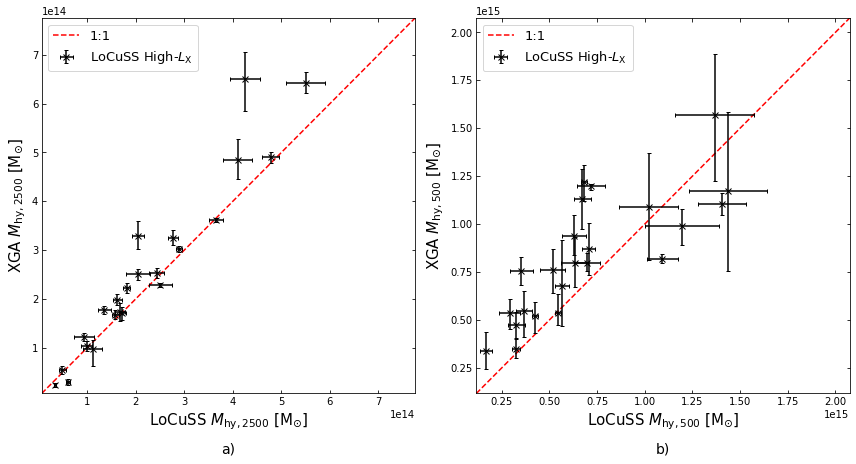

In [10]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_13_m2500, loc_sb_dblbeta_simpvikh_13_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

100%|█████████████████████████████████████████████████████████████████| 30000/30000 [00:26<00:00, 1136.49it/s]


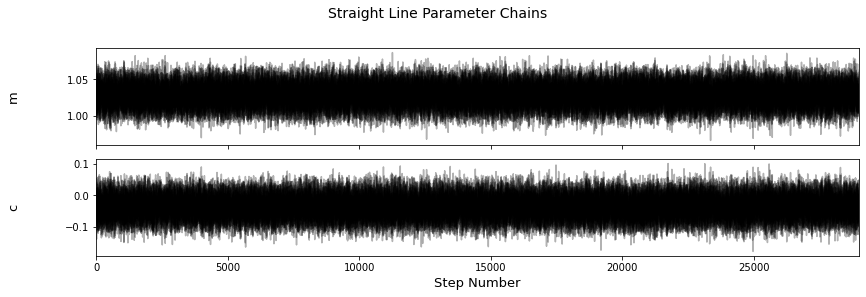

Removed no burn in


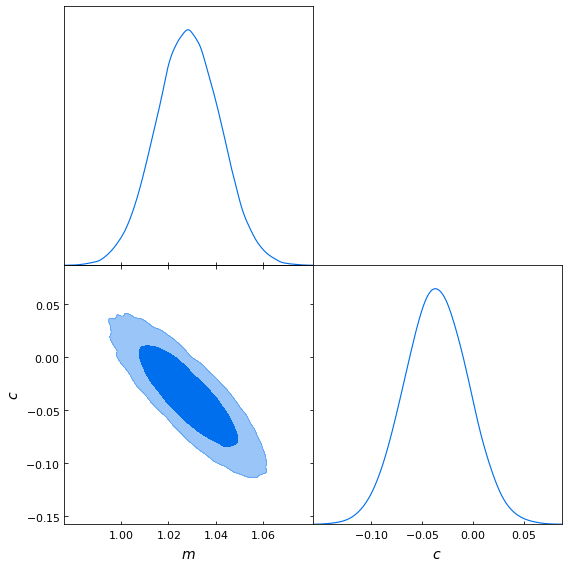

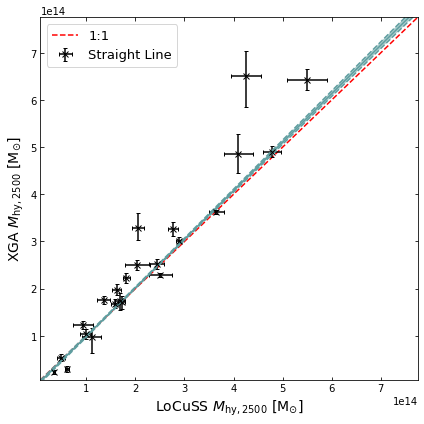

m=1.028 +0.014 -0.014 [1sig]
c=-0.036 +0.032 -0.032 [1sig]


In [11]:
fit_comp(loc_lit_m2500s, loc_sb_dblbeta_simpvikh_13_m2500, [[-5, 5], [-5, 5]], 
         r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", view_chains=True,
         view_corner=True, norm=Quantity(1e+14, 'Msun'), linear=True, xscale='linear', yscale='linear')

100%|█████████████████████████████████████████████████████████████████| 30000/30000 [00:26<00:00, 1129.20it/s]


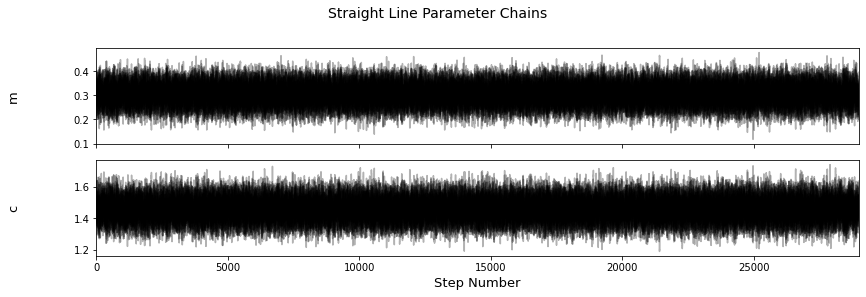

Removed no burn in


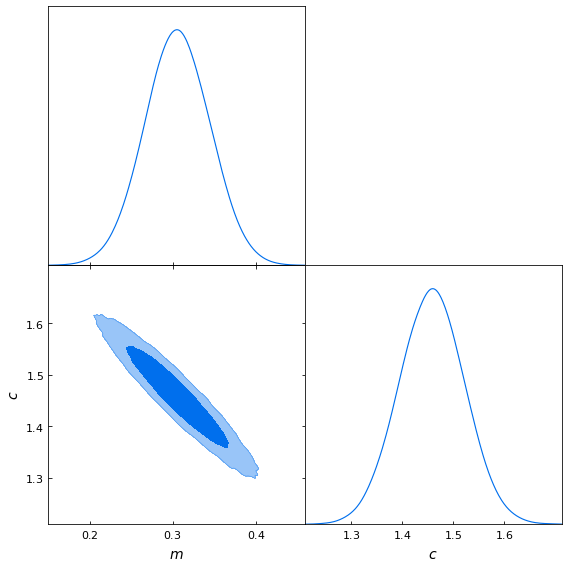

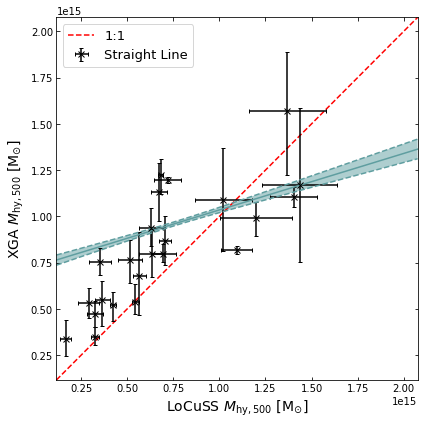

m=0.305 +0.04 -0.039 [1sig]
c=1.458 +0.064 -0.065 [1sig]


In [15]:
fit_comp(loc_lit_m500s, loc_sb_dblbeta_simpvikh_13_m500, [[-5, 5], [-5, 5]], 
         r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]", view_chains=True,
         view_corner=True, norm=Quantity(5e+14, 'Msun'), linear=True, xscale='linear', yscale='linear')

#### Problematic Cluster

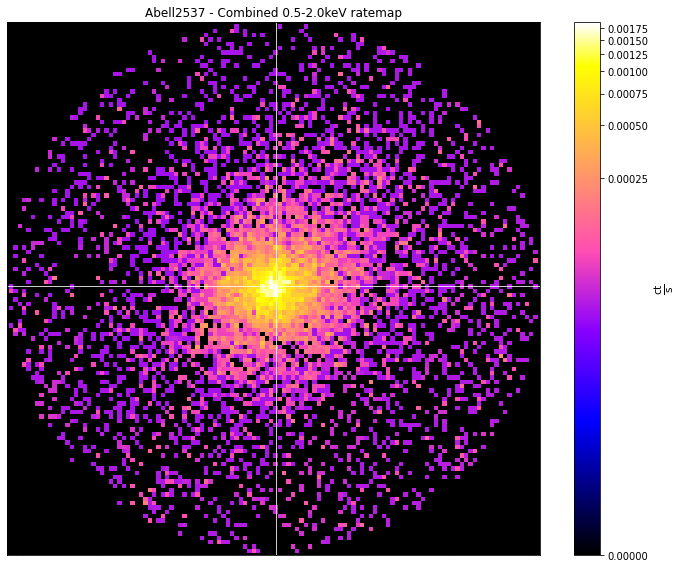

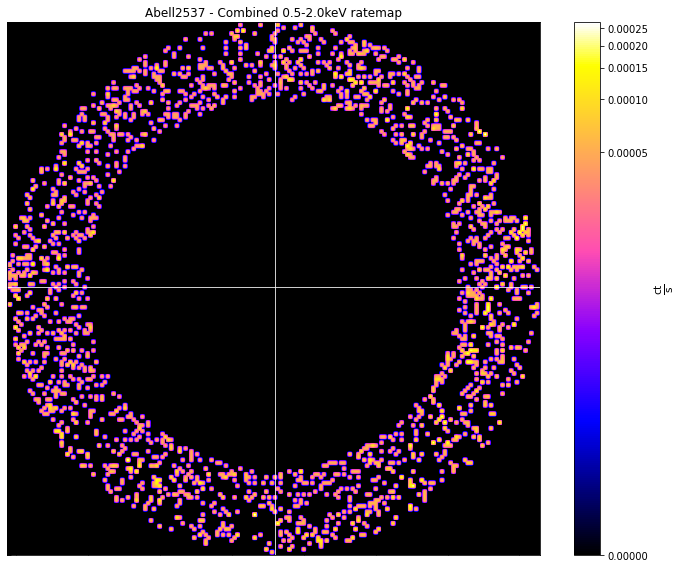

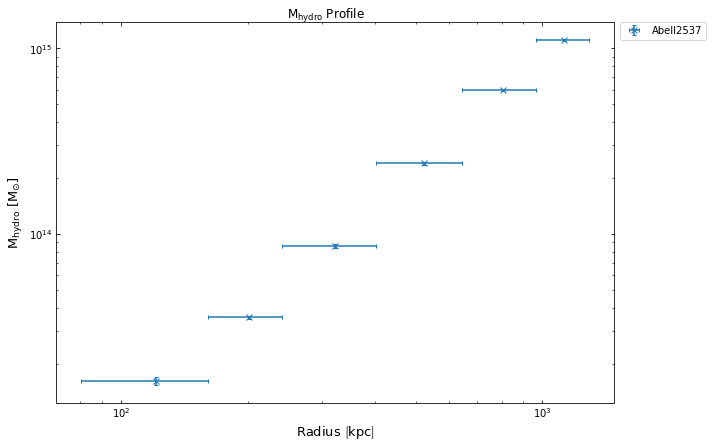

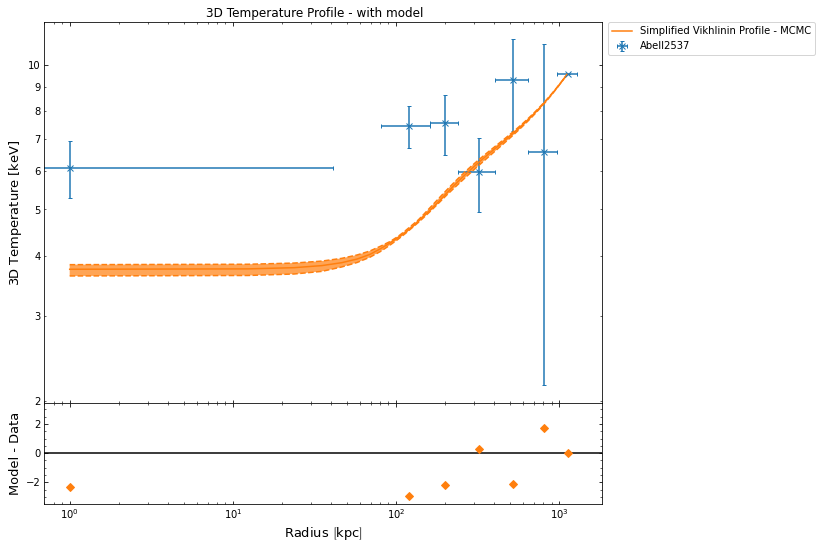

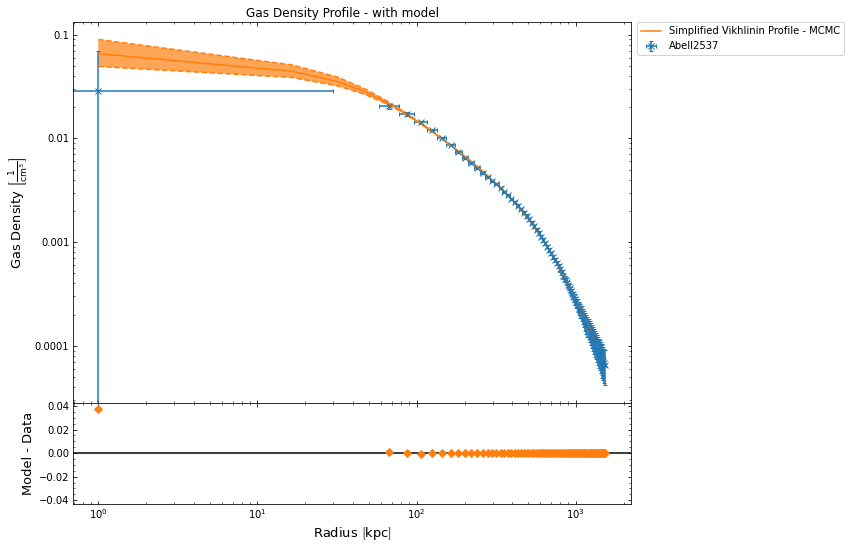


-----------------------------------------------------
Source Name - Abell2537
User Coordinates - (347.092, -2.19122) degrees
X-ray Peak - (347.092, -2.19122) degrees
nH - 0.0545 1e+22 / cm2
Redshift - 0.297
XMM ObsIDs - 1
PN Observations - 1
MOS1 Observations - 1
MOS2 Observations - 1
On-Axis - 1
With regions - 1
Total regions - 34
Obs with 1 detection - 1
Obs with >1 matches - 0
Images associated - 9
Exposure maps associated - 6
Combined Ratemaps associated - 2
Spectra associated - 6
Fitted Models - constant*tbabs*apec
R500 - 1180.0 kpc
R500 SNR - 98.42
R2500 - 510.0 kpc
R2500 SNR - 79.2
R500 Tx - 7.21±0.305[keV]
R500 0.5-2.0keV Lx - 3.87±0.055[e+44 erg/s]
-----------------------------------------------------



In [13]:
problem_src = locuss_srcs[42]
problem_mp = loc_sb_dblbeta_simpvikh_13_mp[42]
problem_src.get_combined_ratemaps().view(problem_src.ra_dec, problem_src.get_mask('r500')[0], zoom_in=True)
problem_src.get_combined_ratemaps().view(problem_src.ra_dec, problem_src.get_mask('r500')[1], zoom_in=True)
problem_mp.view()
problem_mp.temperature_profile.view()
problem_mp.density_profile.view()
problem_src.info()

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.2$R_{500}$

In [5]:
loc_sb_dblbeta_simpvikh_12_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.2, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 576/576 [51:23<00:00,  5.35s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0068 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0697 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0773 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mn

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1043.55866231  689.26008343  935.9020224  1089.37955788 1104.37780278
  926.38954697]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▍       | 2/34 [00:51<13:32, 25.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1698.23498647  454.52212836 1704.96043228 1195.56197617 1474.5489096
 1653.93679724]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 3/34 [01:14<12:37, 24.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 626.45311726 1533.82821179 1051.75070452 1497.71641703 1604.92541687
 1693.10830439]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█▏      | 5/34 [02:04<11:57, 24.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1213.70356855 1793.92888924  899.14347244 1224.66779958 1160.78555198
 1122.97987081]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▋      | 7/34 [02:55<11:23, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 179.08992793  178.22730784 1543.68227189 1502.56557851 1575.93078561
 1469.8135118 ]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██▎    | 11/34 [04:41<09:56, 25.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1521.17126334 1240.54122222 2006.91467579 2026.8937692  2090.57183638
 2000.36191771]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 12/34 [05:07<09:34, 26.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1036.20850056 1023.2068728   897.31904567  635.13047851  773.10320995
 1000.31466006]


Fitting data, inverse Abel transforming, and measuring densities:  41%|██▉    | 14/34 [05:56<08:21, 25.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 509.72819427  856.76263391 1872.76566145 1998.63326552 1733.75450765
 1844.71871027]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 18/34 [07:44<06:54, 25.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 603.66333846  951.93358219 2070.0130097   968.08200003  864.61129831
 2054.26739644]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 911.577627    961.0898286  2247.05206714 1434.9395823  1618.75417843
 2189.16370084]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 20/34 [08:41<06:26, 27.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 731.49628993  738.33688364 1338.2816096  1183.97146544  949.85408851
  934.50777272]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 25/34 [10:58<04:03, 27.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 725.63933713  756.67993629 1702.75119963 1134.76372452 1060.57207134
 1701.87387352]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 26/34 [11:23<03:33, 26.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1094.22886371  920.92413778 1159.91770197 1314.2243804  1340.75661447
 1191.82870357]


Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▊ | 28/34 [12:19<02:44, 27.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [506.99787026 738.57368688 905.3460775  525.98177827 555.65502471
 738.1865501 ]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 33/34 [14:37<00:26, 26.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 939.90100735  803.35585524 1651.11963181 1335.8883925  1448.09339929
 1668.16902982]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 34/34 [15:01<00:00, 26.52s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 256.50656445  328.18708382 1236.51206342  976.55573826  678.44714166
 1176.60319953]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1008.8482569   979.53310013 1110.27555579  565.1475301  1158.24474103
  706.65236528]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/46 [00:49<36:16, 49.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [359.16208406 606.14275006 364.1830019  346.59667752 346.66747646
 394.65363499]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [115.38563319 167.83039413 555.68507913 109.9316603  111.70477945
 318.33610033]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/46 [01:38<22:12, 30.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [408.10850186 483.30026671 438.88455925 447.34798945 518.12913088
 403.38453948]


Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/46 [02:27<26:01, 37.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1220.78050859  857.32625792 1042.55833366  840.89560375 1114.74298876
  740.48521172]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/46 [03:14<27:44, 40.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 620.92979498 1079.62587991 2285.68755382  738.97544429  697.38099357
 1408.97304292]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/46 [04:01<28:19, 42.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [106.67863013  99.47852226 715.30503859 126.92431161 115.47910584
  95.03814425]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 638.94717101 1052.57315028  679.59285488  695.96512814  456.3608425
  627.70369258]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 606.09715974 1068.13687375 1382.76334601  440.7506383   625.10273366
 1274.54123068]


Generating Abell0267 hydrostatic mass profile:  15%|████                       | 7/46 [04:53<29:37, 45.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 386.07028375  784.1496614   428.361046    474.22040666 1085.25829203
  403.54151314]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.6691545   95.33621689 483.0695499   99.92656854 120.34860279
  95.5178333 ]


Generating Abell0383 hydrostatic mass profile:  20%|█████▎                     | 9/46 [05:43<28:49, 46.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1415.61392009 1766.44815738 1276.183845   1214.66693079 1927.54143844
 1475.99656152]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.30022612  87.01053978 777.3209902   85.18303786  85.79506555
  88.47407315]


Generating Abell0521 hydrostatic mass profile:  22%|█████▋                    | 10/46 [06:34<22:04, 36.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 568.75884822  721.6773891   901.31407576 2101.59942734  539.75881862
 1102.50541827]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1406.49976535 1572.63883043  827.075145   1458.36345475 1533.28415215
  905.31813591]


Generating Abell0586 hydrostatic mass profile:  24%|██████▏                   | 11/46 [07:23<23:15, 39.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [350.80224798 868.57875772 367.95894427 500.78883052 434.97876096
 357.30368358]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.07275459 100.50572453 549.67208256 101.75156268 130.03483314
 105.6369013 ]


Generating Abell0611 hydrostatic mass profile:  26%|██████▊                   | 12/46 [08:13<24:07, 42.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [470.68828031 982.55193638 870.86589912 887.68644725 455.65126675
 522.06276497]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [386.42767942 587.13878682 660.21906706 249.72368967 190.8784927
 659.35834234]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|██████              | 14/46 [09:02<23:35, 44.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [944.30196663 774.73363696 719.29376818 359.59250251 863.47644817
 821.25694643]


Generating Abell0750 hydrostatic mass profile:  33%|████████▍                 | 15/46 [09:54<18:46, 36.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.81595661 101.89002206 629.4298632  100.70603849 113.39600252
 116.73358899]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1005.92212995 1517.36495442 1284.90280969 1363.06925171  663.31747659
 1103.57378061]


Generating Abell0750 hydrostatic mass profile:  35%|█████████                 | 16/46 [10:41<19:25, 38.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1207.31289216 1214.95547334 1360.57759269 1595.18161529  610.27031388
 1472.02187118]


Generating Abell0781 hydrostatic mass profile:  37%|█████████▌                | 17/46 [10:41<18:46, 38.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1199.15211363 1529.14060109 1128.95587477  981.80063909  816.94697857
  744.68133542]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2080.42804114 2106.69162483  444.33011505 1404.34066696 2093.75020431
  420.33526103]


Generating Abell0901 hydrostatic mass profile:  39%|██████████▏               | 18/46 [11:29<15:20, 32.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.68078714  88.03344597 848.07304985  87.35042381  84.65528007
  86.19153095]


Generating Abell0907 hydrostatic mass profile:  41%|██████████▋               | 19/46 [12:25<17:07, 38.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [551.57936829 597.58231361 229.83235886 402.95521439 323.68134114
 278.61923179]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|█████████▏          | 21/46 [13:19<17:28, 41.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1886.19333959 1676.64053373 1692.04814797 1992.00876503 1056.49105996
 1121.64998176]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.02635424  97.18549188 812.42746367  74.78866776 118.53460918
  72.44513613]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|██████████          | 23/46 [14:09<13:22, 34.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [391.81645272 929.36208003 615.25209977 599.87816842 417.57983469
 395.5685848 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 939.52956875  879.57163159  507.99381412 1123.76385512  481.41293548
  785.24558256]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|██████████▍         | 24/46 [14:52<11:01, 30.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1815.87707716 1637.67961841 2065.86672377 1366.55634292  730.77699047
 1264.50630047]


Generating Abell1689 hydrostatic mass profile:  54%|██████████████▏           | 25/46 [15:43<12:00, 34.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1035.66569355 1269.59053704 1228.54821897 1183.42134415  798.5291894
  878.60520772]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.25453512  88.78314525 539.08041107  83.50585996  83.76164143
  84.74998004]


Generating Abell1763 hydrostatic mass profile:  59%|███████████████▎          | 27/46 [16:39<12:28, 39.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [272.65647311 420.12151218 327.81207708 316.54092591 294.52445427
 317.57464635]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  93.03314417  100.45804138 1129.70646807  107.18356388  107.24279517
  105.96579099]


Generating Abell1835 hydrostatic mass profile:  61%|███████████████▊          | 28/46 [17:29<10:07, 33.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1469.83109523 1491.2692398  1319.2553143  1648.21724449  501.69315641
 1013.55555983]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.54289279  82.5255887  453.28546692  77.07090517  74.96811376
  62.23924723]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|█████████████       | 30/46 [18:23<10:11, 38.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1447.2786145  1529.84044193 1303.45567404 1560.26608084 2139.15103456
 1290.75928454]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 100.19211636  100.71718662 1074.60169616  100.37522419  110.14434427
   93.68694161]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▌        | 31/46 [19:11<08:09, 32.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [667.69864108 563.17749087 566.58124159 414.59859092 306.57443129
 294.98073825]


Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|█████████████▉      | 32/46 [20:08<08:51, 37.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [511.94547309 631.16510601 508.35105028 416.71516505 386.22733923
 484.01219402]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1102.91581237 1023.97710528  297.54978915  955.88496237  425.79816872
  320.95846598]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████▎     | 33/46 [20:55<08:39, 39.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  67.20329963   59.02082699 1186.9773431    73.31028808   69.3645891
   38.13838841]


Generating Abell2111 hydrostatic mass profile:  74%|███████████████████▏      | 34/46 [21:51<08:49, 44.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [218.97674553 459.89704104 312.36582724 361.80908599 337.50630875
 274.60240053]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [338.47289775 530.19825418 613.53113847 224.32160129 134.90155124
 592.9685735 ]


Generating Abell2219 hydrostatic mass profile:  78%|████████████████████▎     | 36/46 [23:42<08:18, 49.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [303.95674761 428.52066877 497.95431796 460.29108286 454.97381067
 523.79203933]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▉    | 37/46 [24:38<07:43, 51.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [759.58561974 476.76630727 156.73281282 757.20099947 279.14128966
 337.96875373]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 81.38924594  82.90311304 593.98995134  80.9001705   88.15286632
  62.42628329]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|████████████████▉   | 39/46 [25:35<06:11, 53.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [484.7950152  658.1916649  520.09482045 468.19444976 352.56530208
 373.81013126]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.65231427 103.7372462  403.73042749  97.28730737 115.05383152
 111.0126649 ]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▎  | 40/46 [26:26<04:03, 40.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1038.44184185 1152.87156633 1056.37082956 1154.91798321  448.80094361
  621.78092201]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 81.00067007  82.69275258 516.87553766  78.98313719  88.280331
  81.12043786]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 44/46 [27:17<01:26, 43.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [390.78486219 387.74963662 369.61443092 393.95640885 417.34062995
 316.45240242]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 45/46 [28:07<00:25, 25.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [379.00701171 611.5844091  441.73576624 549.31525388 353.38534635
 347.01916689]


Complete: 100%|███████████████████████████████████████████████████████████████| 46/46 [28:56<00:00, 37.76s/it]


In [6]:
loc_sb_dblbeta_simpvikh_12_m500 = []
loc_sb_dblbeta_simpvikh_12_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_12_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_12_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_12_m500.append(m)
        loc_sb_dblbeta_simpvikh_12_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_12_m500 = Quantity(loc_sb_dblbeta_simpvikh_12_m500)
loc_sb_dblbeta_simpvikh_12_m2500 = Quantity(loc_sb_dblbeta_simpvikh_12_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 46/46 [00:00<00:00, 51.04it/s]


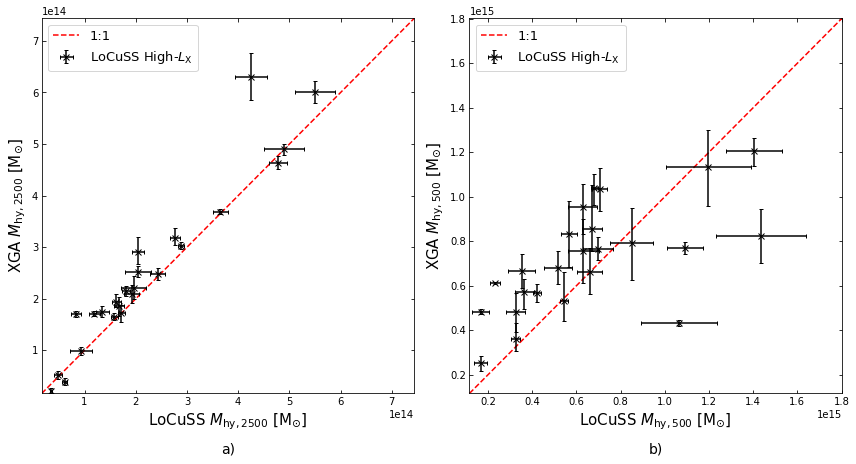

In [7]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_12_m2500, loc_sb_dblbeta_simpvikh_12_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.1$R_{500}$

In [8]:
loc_sb_dblbeta_simpvikh_11_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.1, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Generating products of type(s) spectrum: 100%|████████████████████████████| 216/216 [1:28:54<00:00, 24.70s/it]
Generating products of type(s) annular spectrum set components: 100%|███| 2706/2706 [2:33:30<00:00,  3.40s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 554/554 [48:38<00:00,  5.27s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0697 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1031.20642258  999.94002192 1715.03532944 1602.23326059 1723.19114701
 1744.06534676]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 2/38 [00:54<16:34, 27.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [452.32017372 336.56805474 403.31543448 387.36058477 385.90708865
 399.61908155]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 3/38 [01:19<15:12, 26.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1697.27078901  801.62429397 1670.93904081 1446.27623868 1534.15306826
 1515.07950434]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▊       | 4/38 [01:42<14:08, 24.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 837.93423736 1677.32997081 1482.11930861 1432.42906851 1512.98112483
 1670.14581735]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 5/38 [02:06<13:37, 24.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [336.52288428 540.72645256 236.04211437 215.71886847 346.09754597
 294.32005562]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▎      | 6/38 [02:31<13:17, 24.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [127.08348548 464.1981728  506.1980881  388.95484625 432.60880966
 513.62868831]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▋      | 8/38 [03:24<12:46, 25.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 215.60190842  327.95379709 1830.59898341 1673.21967492 1762.11385026
 1782.50915309]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▉      | 9/38 [03:52<12:43, 26.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [453.71916515 435.54863849 347.56881535 367.44847434 401.10384991
 434.06846945]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 13/38 [05:37<10:50, 26.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1684.24037925  635.72102501 1716.31750617 1693.75840523 1813.6896017
 1671.24198171]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 14/38 [06:03<10:25, 26.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [854.05215089 848.48940013 750.9445432  707.63431199 761.52472323
 858.86989982]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 16/38 [06:54<09:30, 25.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 691.14251789  478.33170577 1964.68263222 1558.28320777 1635.15723817
 1791.37466338]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 311.16372239  829.12560776 1893.46460454 2387.99623765 2343.45330787
 1852.78416585]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 20/38 [08:43<08:15, 27.52s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of RXCJ1212.3-1816's

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 476.46011271  829.2973248  1324.51542799 1049.3678199   976.13971132
 1311.34420145]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 22/38 [09:28<06:42, 25.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 907.48888501  973.89209902 1970.78182884 1570.13889922 1705.34111196
 1922.41486654]


Fitting data, inverse Abel transforming, and measuring densities:  63%|████▍  | 24/38 [10:24<06:08, 26.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1403.93061441 1427.28047248 1911.56205519 1723.85315713 1734.34211898
 1817.93564258]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 28/38 [12:12<04:23, 26.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 841.93280309  969.37750734 2120.95088312 1111.07925081 1623.77987268
 2123.802327  ]


Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 30/38 [13:03<03:28, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1065.6417929   907.72508149 1035.66696929 1043.20709196 1056.47144105
 1042.31152352]


Fitting data, inverse Abel transforming, and measuring densities:  92%|██████▍| 35/38 [15:20<01:19, 26.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1180.29973262  794.45587904 1219.19400186 1140.90748773 1244.41550384
 1267.17162209]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 36/38 [15:46<00:52, 26.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [534.50006282 522.5873435  581.37045165 313.54833602 440.17435863
 607.04507832]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 37/38 [16:10<00:25, 25.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1200.58273815  975.11747727 1738.32243231 1451.34725848 1128.33474986
 1730.04081943]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 38/38 [16:34<00:00, 26.17s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [383.28912914 734.20383958 843.68663284 667.7135055  739.68403526
 881.51961049]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [644.79293612 750.7423562  468.55535449 633.18406194 905.95262138
 368.49954323]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.19334991 122.30803845 762.56502234 115.46097083 117.51833221
 268.58515964]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/46 [00:49<37:20, 49.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [831.38696046 630.33875891 919.15114457 852.52622665 811.19137595
 594.29115218]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [172.26393658 234.71750004 667.32188663 138.29074612 109.99650923
 290.88655353]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/46 [01:40<36:59, 50.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [462.65947889 667.37665262 471.96282943 392.9586419  495.80467891
 437.92702784]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [135.39691202 209.15726517 751.79380116 120.55988055 119.97806437
 449.12541246]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/46 [02:29<35:28, 49.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [417.43494667 762.00641294 546.1448476  524.83290208 384.89491873
 477.57641713]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/46 [03:17<34:28, 49.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 947.21761967 1015.99791676 1079.35730087 1170.40843494 1035.58554418
  635.48177338]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [129.91733188 220.68348514 742.2926963  120.93017613 114.27377401
 216.16688161]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/46 [04:05<33:17, 48.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 707.97357522 1118.39746644  711.22755338  479.76103798  877.70961634
  657.17322906]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/46 [04:52<32:04, 48.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 112.73932616  110.0298817  1240.66219789  107.27915624  116.51101784
  101.18453114]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [518.00436629 920.40510588 594.36034797 675.39766301 714.04568398
 579.9961159 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [115.84169524 125.84784797 414.6442547  105.7589596  116.56955096
 133.46045065]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|████                       | 7/46 [05:44<32:02, 49.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [442.11982749 605.9610475  503.17738128 440.39452419 908.5791559
 279.30156157]


Generating Abell0291 hydrostatic mass profile:  17%|████▋                      | 8/46 [06:33<31:10, 49.23s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 578.75077865 1193.16892868 1161.87515674  508.34844283  826.07650738
  921.40920503]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0383 hydrostatic mass profile:  20%|█████▎                     | 9/46 [07:22<30:22, 49.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1216.53824986 1159.19960461  933.2420722  1173.19373405 1303.38895702
  783.43188651]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.70523079  96.34107118 900.41621163  86.22080626  85.59464396
  93.33828802]


Generating Abell0521 hydrostatic mass profile:  22%|█████▋                    | 10/46 [08:14<30:03, 50.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [681.76670878 707.79898428 440.52667611 632.34452496 501.07290271
 453.42552947]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1336.32326401 1439.76489891  938.83746012 1234.59539682 1498.38595341
  953.98870945]


Generating Abell0586 hydrostatic mass profile:  24%|██████▏                   | 11/46 [09:03<28:59, 49.69s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [509.88699404 750.93103598 511.34138782 558.5626108  406.76975541
 488.66470344]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|██████▊                   | 12/46 [09:53<28:13, 49.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 502.21473789 1308.76472788  564.07765175  565.06886402  475.79636439
  443.86604251]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [324.24122334 418.15694001 456.32303148 282.8461201  156.28656419
 451.66003693]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|██████              | 14/46 [10:41<26:17, 49.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1610.08636531 1432.71656273  986.6188559   812.45383074  832.76362718
  955.86189131]


Generating Abell0750 hydrostatic mass profile:  33%|████████▍                 | 15/46 [11:28<19:16, 37.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.7955186  108.88344787 934.33393588 103.13133109 114.88833058
 124.16170834]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1113.12529629 1111.87486748 1129.55003105 1028.94807793  991.39067341
  917.37512616]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1274.68864873 1246.92138618 1103.79177027 1442.91295424  775.75889373
 1242.19147222]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0773 hydrostatic mass profile:  35%|█████████                 | 16/46 [12:15<19:49, 39.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [428.91913142 515.10524365 457.88026793 394.34300541 330.55015837
 373.11700702]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 99.03115955  97.28020655 820.23982801  99.92136418 131.52456502
 102.29677961]


Generating Abell0781 hydrostatic mass profile:  37%|█████████▌                | 17/46 [13:04<20:22, 42.15s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for Abell0781 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating Abell0901 hydrostatic mass profile:  39%|██████████▏               | 18/46 [13:04<19:40, 42.15s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1528.679712   1871.30414415 1496.30170704 1311.77921266 2029.86172198
 1528.05758299]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.32016598  79.63380815 864.64170276  86.77496874  85.08535482
  77.75438775]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0907 hydrostatic mass profile:  41%|██████████▋               | 19/46 [13:55<15:43, 34.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [565.58129391 610.60100483 250.58834429 411.4345608  266.29898056
 270.7772401 ]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|█████████▏          | 21/46 [14:49<16:24, 39.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [681.77133659 739.11972458 629.71060009 896.59795461 295.9993921
 383.21327266]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|██████████          | 23/46 [15:40<12:58, 33.85s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for RXCJ1212.3-1816 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|██████████▍         | 24/46 [15:40<12:24, 33.85s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1364.31323097 1030.75930227 2148.75940733 1490.03432577  714.86001802
 1069.37415726]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|██████████████▏           | 25/46 [16:30<09:03, 25.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1137.17396981 1320.76422697 1239.93877839 1208.58492611  966.65943938
  900.8838502 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.25235191  81.79866976 864.82345976  90.35062475  80.86233736
  79.04686198]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1763 hydrostatic mass profile:  59%|███████████████▎          | 27/46 [17:24<09:51, 31.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [333.90187718 431.67448408 416.20644753 413.97145231 448.04068179
 438.67865416]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 107.07642851  106.49691075 1180.91450694  163.51512963  169.03532601
  111.14562617]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1835 hydrostatic mass profile:  61%|███████████████▊          | 28/46 [18:15<08:44, 29.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 906.83580157  903.23390314  943.16237949 1148.05729451  365.26250078
  516.22173684]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 76.8074055   80.32644895 459.99082568  78.88712416  76.79137714
  70.17407447]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|█████████████       | 30/46 [19:10<09:08, 34.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1275.66864331 1520.48173245 1382.20259327 1213.2782129  2055.58682049
 1134.77368525]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.70735476  95.32099321 971.02697785 103.17949588 129.63466294
  93.84015026]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▌        | 31/46 [19:58<07:38, 30.59s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [365.67111748 483.56921066 606.6519993  304.31198787 220.50712601
 258.76480115]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|█████████████▉      | 32/46 [20:54<08:20, 35.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [460.95401045 576.0243558  537.36866331 540.49971248 388.9819779
 550.11981519]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1462.77401168 1302.77750097  688.49894092 1411.65158924 1053.72650641
  847.37473139]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████▎     | 33/46 [21:40<08:12, 37.90s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 990.0207436  1099.11767862  613.55547506 1082.27820092  334.17414003
  599.79326933]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  56.88902265   62.50596404 1135.85356916   78.41249332   81.10476329
   30.47876115]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2111 hydrostatic mass profile:  74%|███████████████████▏      | 34/46 [22:35<08:24, 42.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [285.62533881 544.25912533 421.1001714  308.37842909 312.18824622
 269.16116093]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 321.99515308  694.35800725 1053.38346193  204.91882471  146.79560458
  860.16155346]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▊      | 35/46 [23:26<08:08, 44.36s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▉    | 37/46 [24:25<07:15, 48.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [820.84033343 494.98441197 160.1291934  807.36955187 305.79894939
 370.28663496]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 71.91189     72.61199138 745.05039877  83.83512102  85.56011514
  75.13703426]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|████████████████▉   | 39/46 [25:21<04:37, 39.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 746.58145725 1180.73954246  449.28210523  809.05067247  569.71957983
  507.51485898]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.96993075  98.73586473 469.18140747  99.87713262 122.61483752
 101.27145826]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▎  | 40/46 [26:11<03:23, 33.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1208.16667966 1379.32493289 1222.78463603 1432.15645815  521.50784859
  578.57070288]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 42/46 [27:02<02:30, 37.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [375.71005436 613.53464236 475.77015162 429.88384634 349.98265913
 329.2215988 ]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 43/46 [27:52<01:38, 32.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 693.92075702 1136.91160549 1555.8322448   378.13414798  169.2942847
 1314.01129305]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [718.20623784 675.39194719 534.93790324 656.11113836 590.00570984
 588.14250448]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [142.72238151 243.14538664 472.38710797 108.44867423 136.41793367
 272.74741846]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 44/46 [28:42<01:12, 36.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [366.2427071  491.75885975 410.48231384 430.92585548 388.19831664
 302.38174263]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 45/46 [29:31<00:39, 39.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [497.38562239 546.99671197 512.32322928 433.8901729  401.52215349
 429.67614218]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [359.73991047 414.21263509 436.91163711 304.91909388 206.80203328
 444.42009291]


Complete: 100%|███████████████████████████████████████████████████████████████| 46/46 [30:21<00:00, 39.60s/it]


In [9]:
loc_sb_dblbeta_simpvikh_11_m500 = []
loc_sb_dblbeta_simpvikh_11_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_11_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_11_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_11_m500.append(m)
        loc_sb_dblbeta_simpvikh_11_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_11_m500 = Quantity(loc_sb_dblbeta_simpvikh_11_m500)
loc_sb_dblbeta_simpvikh_11_m2500 = Quantity(loc_sb_dblbeta_simpvikh_11_m2500)

Measuring Masses for LoCuSS Clusters:   9%|███▏                                | 4/46 [00:00<00:01, 37.21it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 46/46 [00:00<00:00, 48.22it/s]


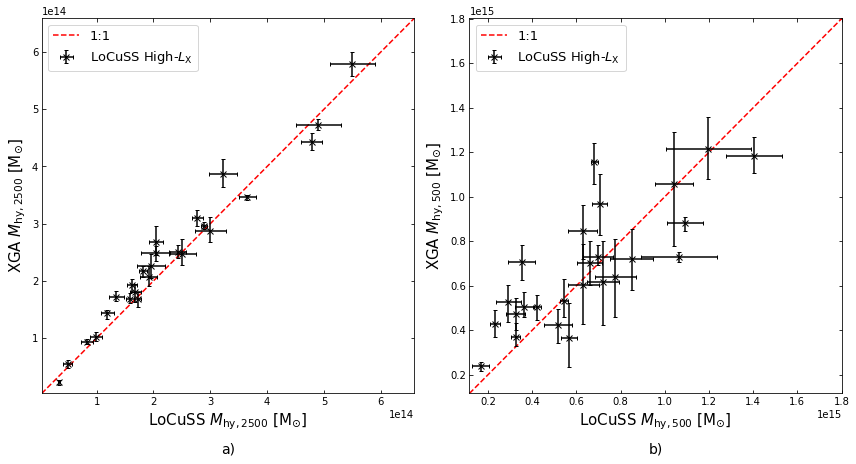

In [11]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_11_m2500, loc_sb_dblbeta_simpvikh_11_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/loc_sb_dblbeta_simpvikh_1.1r500_hymcomp.pdf')